In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Autoencoder Study

## Goal

In this notebook we will study the behaviour of a simple autoencoder when trained to reproduce a step function. We will try answering the following questions:

1. Should we use an activation function at the output? If yes, which one? What are the effects and limitations of the most common activation functions?

2. Should we use an activation function in the hidden layer? If yes, which one? What are the effects and limitations of the most common activation functions?

3. What loss should be used?

4. After relying on an architecture, what is the relation between the input and the ouput? Is it linear? 

5. Can this simple autoencoder capture an amplitude factor? 

6. What types of functions can be reproduced using this autoencoder?

## Architecture

The autoencoder we'll consider has only one hidden layer.

- **Input:** Vector $x$ of dimension $127$ representing the step function
- **Hidden Layer:** Scalar $a$ 
- **Output:** Vector $y$ of dimension $127$ representing the reconstructed step function

## Equations
\begin{align}
z_1 &= \mathbf w_1^T \mathbf x + b_1 \\
a &= g_1(z_1) \\
\mathbf z_2 &= \mathbf w_2 a + \mathbf b_2 \\
\mathbf y &= g_2(\mathbf z_1)
\end{align}

- Where $g_1$ and $g_2$ are activation functions.

- Note that in our case, $\mathbf w_1$ and $\mathbf w_2$ are vectors rather than matrices.


## 1. Output Activation Function

In this part, we will only focus on the output activation function. 

We will assume that the hidden representation $a$ is linear with the position of the step function.

### a. No output activation

\begin{align}
\mathbf y &= \mathbf z_2 = \mathbf w_2 a + \mathbf b_2
\end{align}

This equation is the projection of a scalar onto a higher dimension space. 

After the training, the vectors $\mathbf w_2$ and $\mathbf b_2$ become constant. And only the scalar $a$ will vary with the input.

Thus, such model, without a nonlinear activation function at the output, cannot generate the input data.

Indeed, the input data is a set of linearly independent vectors of dimension $128$. Thus, it is also a set of affinely independent vectors of dimension $128$. However, the output vectors of our model are affinely dependent.

\begin{align}
\forall a' \in \mathbb{R}, \mathbf y' - \mathbf y = \mathbf w_2 (a' -a) \propto \mathbf w_2
\end{align}

**Theoretical conclusion:**

- Hence, we conclude that for such a simple AE, a nonlinearity on the output is necessary.

### b. Sigmoid output activation 

\begin{equation}
\mathbf y = \sigma(\mathbf z_2) = \sigma(\mathbf w_2 a + \mathbf b_2) \\
\mathbf y^{(i)} = \sigma(\mathbf z_2^{(i)}) = \sigma(\mathbf w_2^{(i)} a + \mathbf b_2^{(i)})
\end{equation}

Since the decoder is that simple, we can predict an approximation of the values of the weights $\mathbf w_2$ and the bias $\mathbf b_2$. 

An output neuron $\mathbf y^{(i)} = \sigma(\mathbf w_2^{(i)} a + \mathbf b_2^{(i)})$ is just a sigmoid that is stratched or compressed (and inversed in direction or not) according  to the value of $\mathbf w_2^{(i)}$ and that is translated according to $\mathbf b_2^{(i)}$. This means, that the model uses $\mathbf b_2$ to indicate at which point the step function must switch to $1$. Thus we expect the bias vector $\mathbf b_2$ to be proportional to the vector $(0, 1, 2, ..., 127)$. And $\mathbf w_2$ indicate the strength of the slope. Thus we expect $\mathbf w_2$ to be uniform (for smoothness), high (for sharpness) and negative if $a$ is proportional to the position of the step (step starts with $0$ and not $1$).

These expectations are simulated in the cell bellow.

The slope of the function is also affected by the distance between the $\mathbf b_2^{(i)}$. The larger the distance is, the further the sigmoids are from each other, the harder the slope of the constructed function. Moreover, the values of $a$ shouldn't be necessary at the middle of the sigmoid. In fact, it is better that these values be in the mid-way between two sigmoids so we can obtain only $0$ and $1$ values. This is actually good news, because it means that we can reproduce an exact step function with the same discontinuity and only $0$s and $1$s.

This last paragraph is valable for a fixed value of $z_1$. This means that even if the weights are constant, their values have a big effect in increasing the performance. That's why we won't have our expected results by fixing them.
Hence, we initialize these vectors as uniform but we let them be learnt. This way they will most probab


**Theoretical conclusion:**

- An autoencoder with one hidden layer and one neuron in the hidden layer, can correctly generate step functions.
- A downside of using sigmoids is that the output value must be between $0$ and $1$. Thus we can't use it when the function has a value outside this interval.

Text(0.5, 0, '$a$')

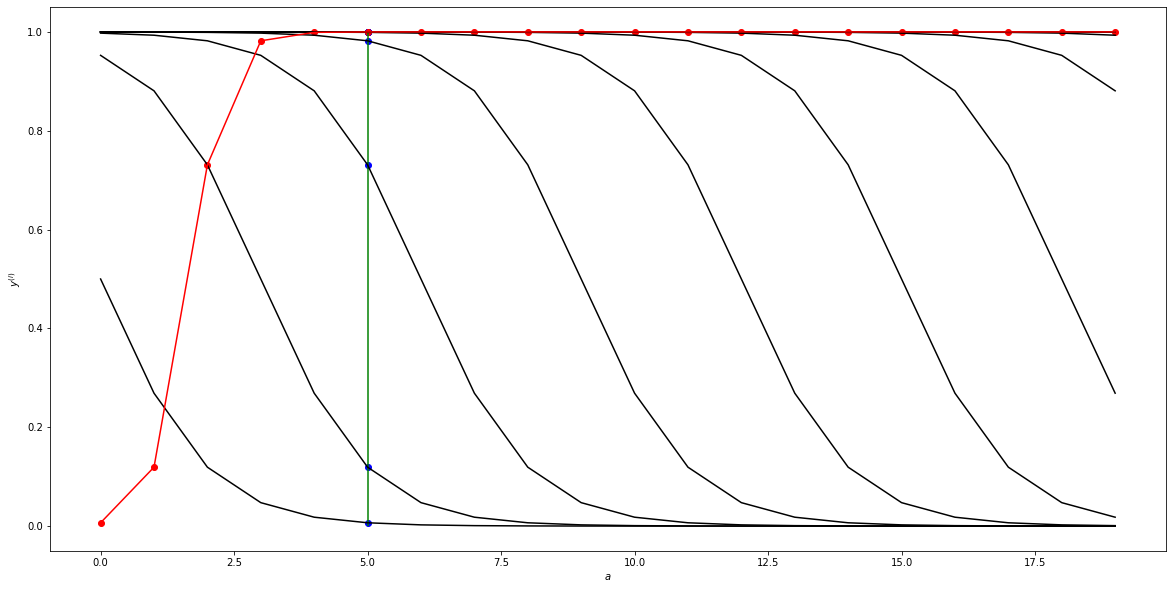

In [ ]:
plt.figure(figsize=(20,10))

l = 20
a_Axis = torch.arange(0,l)

a = 5
w = 1

y =[]

for i in np.arange(l):
  sigmoid = torch.sigmoid(w*(-a_Axis + 3*i))

  plt.plot(a_Axis, sigmoid, 'k')

  plt.scatter(a, sigmoid[a], c='b')

  y.append(sigmoid[a])

plt.vlines(a, ymin=0, ymax=1, color ='g')
plt.plot(a_Axis, y, 'r')
plt.scatter(a_Axis, y, c='r')

plt.ylabel(r'$y^{(i)}$')
plt.xlabel(r'$a$')

### c. ReLU activation function
\begin{equation}
\mathbf y = \max(0, \mathbf z_2) = \max(0, \mathbf w_2 a + \mathbf b_2) \\
\mathbf y^{(i)} = \max(0, \mathbf z_2^{(i)}) = \max(0,\mathbf w_2^{(i)} a + \mathbf b_2^{(i)})
\end{equation}

Here, an output neuron $\mathbf y^{(i)} = \max(0,\mathbf w_2^{(i)} a + \mathbf b_2^{(i)})$ is just a ReLU translated according to $\mathbf b_2^{(i)}$ with a slope strength related to the value of $\mathbf w_2^{(i)}$.

We have a problem with ReLU when using such a simple AE. We are trying to generate a function that is piecewise constant. Thus, for a particular neuron, we need the ReLU to give us $0$s for a set of values of $a$ and $1$s for the remaining values of $a$. However, in the linear part of the ReLU -the non-zero part- the function is linear, and hence can take the value $1$ for only a unique value of $a$ and for any other values of $a$ the neuron cannot be equal to 1.

Suppose we want to generate two step functions $f_1$ and $f_2$ starting respectively at indices $i_1$ and $i_2$ such that $i_1 < i_2$. And let $a_1$ and $a_2$ be the two corresponding hidden representations. Thus $a_1 \neq a_2$. 

**Theoretical Conclusion:**

- Hence we can't obtain a piecewise constant function with ReLU as activation function in such a decoder.

- Generally, for a scalar hidden representation and only one layer in the decoder, in order to generate a piecewise constant function, the output activation function should also be approximetly piecewise constant and should have values equal to the one we wish to have in the output.

  For example, a $\tanh$ is similar to the $sigmoid$ but its constant parts are $-1$ and $1$. In other words, it passes through $0$ in one single point. We can predict that we can't generate different step functions using the $\tanh$.



### Verification of the previous results

Text(0.5, 1.0, 'Step Functions')

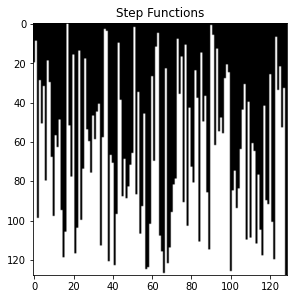

In [ ]:
plt.figure(figsize=(10,5))

# Matrix of step functions
X = torch.zeros(128, 129)

r = torch.randperm(128)
X[:, r] = torch.tril(torch.ones(128, 128))

plt.subplot(121)
plt.imshow(X, cmap='gray')
plt.title("Step Functions")

In [ ]:
class AutoEncoder():

  def __init__(self, n_in, n_h1, n_out, hid_act = 0, out_act = 0):
    
    # Weight Initialization 
    #self.W1 = torch.randn(n_h1, n_in, dtype= torch.float)
    self.W1 = -torch.ones(n_h1, n_in, dtype= torch.float)*0.1
    #self.W1.requires_grad = True #?!

    self.b1 = 128*torch.ones(n_h1, 1, dtype = torch.float)*0.1
    #self.b1.requires_grad = True

    #self.w = - torch.randn(1, 1, dtype=torch.float)
    #self.w.requires_grad = True

    #self.W2 = -torch.randn(n_out, n_h1, dtype= torch.float)
    self.W2 =  -torch.ones(1, 1, dtype=torch.float)*10
    self.W2.requires_grad = True

    #self.b2 = torch.randn(n_out, 1, dtype= torch.float)*0.1
    #self.b2 = torch.ones(n_out, 1, dtype= torch.float)
    self.b2 = torch.unsqueeze(torch.arange(0,128, dtype= torch.float),1)
    self.b2.requires_grad = True

    # Activations
    self.hid_act = hid_act
    self.out_act = out_act

  def forward(self, X):
      z1 = self.W1 @ X + self.b1
      if self.hid_act == 0:
        self.a1 = z1
      elif self.hid_act == 1:
        self.a1 = torch.sigmoid(z1)
      else:
        self.a1 = torch.clamp(z1, min=0)

      # Output Layer
      z2 = self.W2 * torch.ones(n_out, n_h1, dtype = torch.float) @ self.a1 + self.b2
      if self.out_act == 0:
        self.y = z2
      elif self.out_act == 1:
        self.y = torch.sigmoid(z2)
      else:
        self.y = torch.clamp(z2, min =0 )    

      return self.y

  def optim_step(self, alpha = 1e-3, beta = 0):
    with torch.no_grad():

      #self.W1 -= alpha * self.W1.grad

      #self.b1 -= alpha * self.b1.grad

      self.W2 -= alpha * self.W2.grad

      #self.w -= alpha * self.w.grad

      self.b2 -= alpha * self.b2.grad
    
    #self.W1.grad.zero_()
    #self.b1.grad.zero_()
    self.W2.grad.zero_()
    #self.w.grad.zero_()
    self.b2.grad.zero_()

### a. No output activation



In [ ]:
# Model Parameters
n_in = 128
n_h1 = 1
n_out = 128

# Learning Rate 
alpha = 1.5
# Momentum
beta = 0

# Number of epochs
nb_epochs = 1000000

In [ ]:
ae = AutoEncoder(n_in, n_h1, n_out, 0, 1)

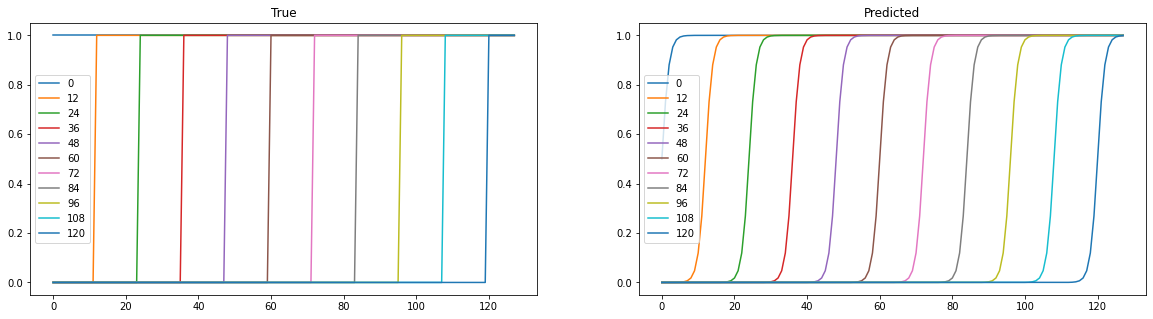

In [ ]:
fig = plt.figure(figsize = (20,5))

axes = fig.subplots(1,2)

for n in np.arange(0, 128, 12):
  axes[0].plot(X[:,r[n]], label = n)
  axes[1].plot(ae.forward(X[:,r[n]]).detach().numpy(), label = n)

axes[0].set_title("True")
axes[0].legend()
axes[1].set_title("Predicted")
axes[1].legend()

b1 = 12.800000190734863


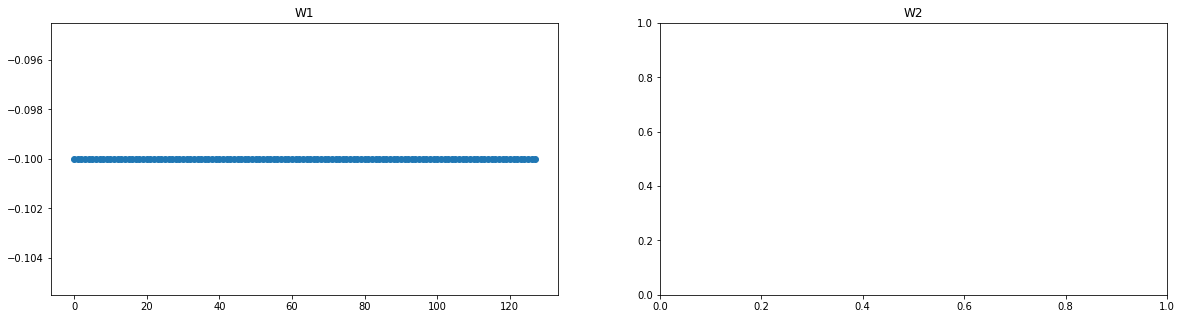

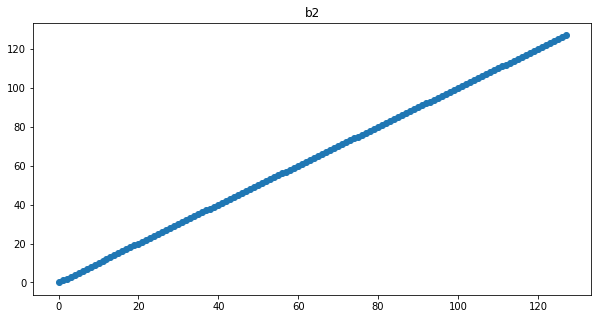

In [ ]:
# Analysing the weights

plt.figure(figsize= (20,5))

plt.subplot(121)
plt.scatter(np.arange(128), ae.W1.detach().numpy()[0])
plt.title("W1")

plt.subplot(122)
#plt.scatter(np.arange(128), ae.W2.detach().numpy())
plt.title("W2")

plt.figure(figsize = (10,5))
plt.scatter(np.arange(128), ae.b2.detach().numpy())
plt.title("b2")

print(f"b1 = {ae.b1.item()}")

In [ ]:
# Training

losses = []

for epoch in range(nb_epochs):
  Y = ae.forward(X)

  loss = nn.MSELoss()(Y, X)
  losses.append(loss)
  
  if (epoch + 1 )%10000 == 0:
    print(f"epoch {epoch + 1} - loss: {loss.item()}")
    #alpha = alpha*0.9

  loss.backward()

  ae.optim_step(alpha, beta)

epoch 10000 - loss: 0.002890925155952573
epoch 20000 - loss: 0.0028635114431381226
epoch 30000 - loss: 0.002852026140317321
epoch 40000 - loss: 0.0028468018863350153
epoch 50000 - loss: 0.00284525565803051
epoch 60000 - loss: 0.0028445457573980093
epoch 70000 - loss: 0.0028443674091249704
epoch 80000 - loss: 0.002844298491254449
epoch 90000 - loss: 0.0028442838229238987
epoch 100000 - loss: 0.0028442787006497383
epoch 110000 - loss: 0.0028442766051739454
epoch 120000 - loss: 0.0028442759066820145
epoch 130000 - loss: 0.0028442759066820145
epoch 140000 - loss: 0.002844275441020727
epoch 150000 - loss: 0.002844275441020727
epoch 160000 - loss: 0.002844275441020727


KeyboardInterrupt: ignored

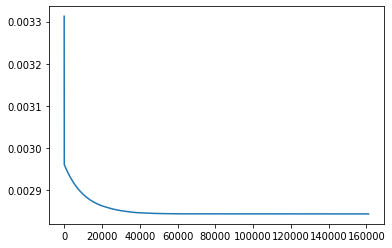

In [ ]:
plt.plot(losses)

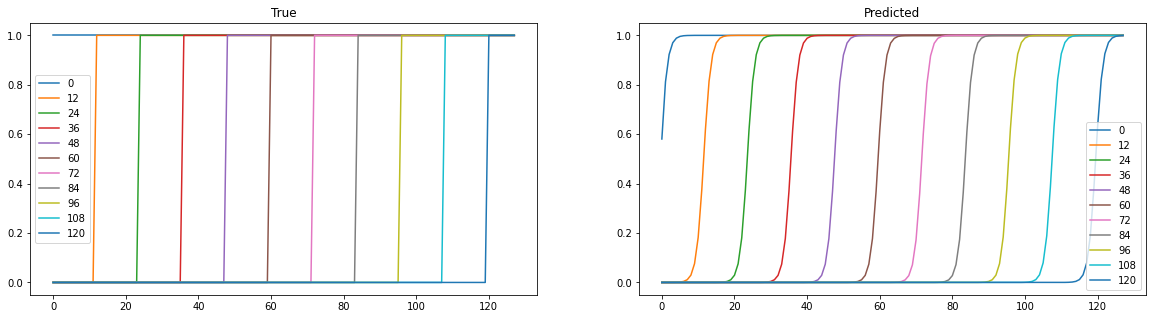

In [ ]:
fig = plt.figure(figsize = (20,5))

axes = fig.subplots(1,2)

for n in np.arange(0, 128, 12):
  axes[0].plot(X[:,r[n]], label = n)
  axes[1].plot(ae.forward(X[:,r[n]]).detach().numpy(), label = n)

axes[0].set_title("True")
axes[0].legend()
axes[1].set_title("Predicted")
axes[1].legend()

b1 = 12.800000190734863
W2 = -9.947271347045898


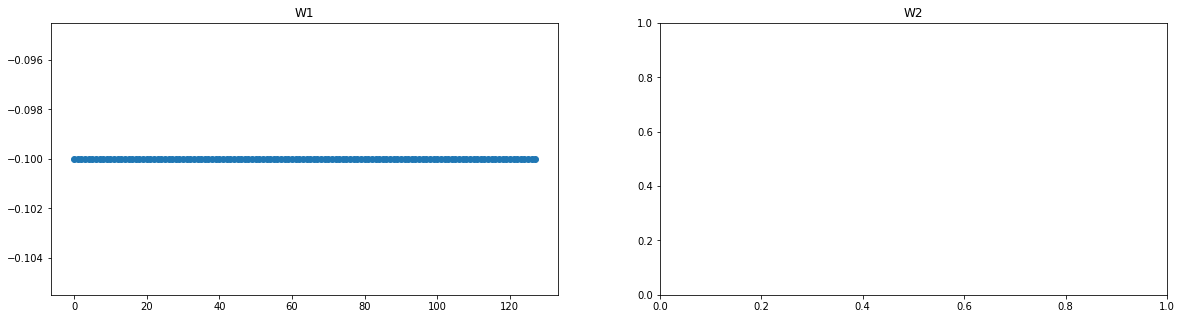

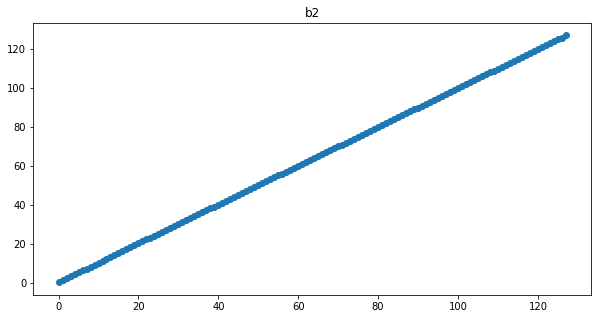

In [ ]:
# Analysing the weights

plt.figure(figsize= (20,5))

plt.subplot(121)
plt.scatter(np.arange(128), ae.W1.detach().numpy()[0])
plt.title("W1")

plt.subplot(122)
#plt.scatter(np.arange(128), ae.W2.detach().numpy())
plt.title("W2")

plt.figure(figsize = (10,5))
plt.scatter(np.arange(128), ae.b2.detach().numpy())
plt.title("b2")

print(f"b1 = {ae.b1.item()}")
print(f"W2 = {ae.W2.item()}")